# TP1: Parcours de protons dans la matière
## PHY-3500: Physique numérique (H2021) - 19 février 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import sympy as sym 
import scipy.constants as sc
from scipy.stats import moyal
import numpy as np
import matplotlib.pyplot as plt

### Question 1

On cherche à exprimer la densité électronique $n_{e}$ en fonction de sa composition atomique et de sa masse volumique $\rho$. On peut d'abord consulter les données du NIST afin de connaître les compositions atomiques de l'eau et de l'os compact ainsi que les énergies moyennes d'excitation $I$.  

On identifie pour l'eau (liquide):
- Densité $\rho$ (g/cm$^{3}$) = 1.00E+00
- Énergie d'excitation moyenne (eV) = 75.00
- Composition:
     - Numéro atomique 1 = 0.111894 (fraction par poids)
     - Numéro atomique 8 = 0.888106 (fraction par poids)

On identifie pour l'os compact (ICRU):
- Densité $\rho$ (g/cm$^{3}$) = 1.85E+00
- Énergie d'excitation moyenne (eV) = 91.90
- Composition:
    - Numéro atomique 1 = 0.063984
    - Numéro atomique 6 = 0.278000
    - Numéro atomique 7 = 0.027000
    - Numéro atomique 8 = 0.410016
    - Numéro atomique 12 = 0.002000
    - Numéro atomique 15 = 0.070000
    - Numéro atomique 16 = 0.002000
    - Numéro atomique 20 = 0.147000

On sait que la densité électronique d'un matériau peut être déterminé à l'aide de la formule suivante (https://en.wikipedia.org/wiki/Bethe_formula):

$$ n_e = \dfrac{N_A \cdot Z \cdot \rho}{A\cdot M_u}, $$

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $A$ est la masse atomique relative et $M_u$ est la constante de masse molaire qui vaut 1 g/mol. 

Comme les matériaux observés sont composés de plusieurs éléments différents, on peut réécrire la densité électronique de la façon suivante:

$$ n_e = \dfrac{N_A \rho}{M_u} \sum_{i} \dfrac{Z_i \xi_{i}}{A_{i}}, $$

où $\xi$ est l'abondance relative de l'élément $i$ (Physique atomique et nucléaire, Jean-François Fortin). 

Par ailleurs, on sait que l'énergie cinétique est liée au facteur $\gamma$ de Lorentz de la façon suivante :

$$T = (\gamma - 1) m_0 c^2,$$

alors, on a évidemment que

$$\implies \gamma = \frac{T}{m_0 c^2} + 1.$$

On peut aussi lié les facteurs $\gamma$ et $\beta$ de Lorentz en sachant que

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}},$$

et donc que

$$\implies \beta = \sqrt{1 - \frac{1}{\gamma^2}}.$$

On implémente l'ensemble des propriétés des deux milieux à l'étude dans une classe nommée « Medium ». Le calcul du pouvoir d'arrêt collisionnel sera réalisé dans cette classe.

In [2]:
class Medium:
    """
    Cette classe définit les propriétés des matériaux
    dans lesquels les protons sont propagés.
    """
    
    # Densité des milieux (rho) [g/cm^3]
    _densities: dict = {
        'Water': 1.0,
        'ICRU': 1.85
    }
    
    # Énergies moyennes d'excitation (I) [eV]
    _mean_excitation_energies: dict = {
        'Water': 75.00,
        'ICRU': 91.90
    }
    
    # Masse atomique relative de l'élément i (A_i) [-]
    _relative_atomic_mass: dict = {
        1: 1.00784,
        6: 12.0107,
        7: 14.0067,
        8: 15.999,
        12: 24.305,
        15: 30.9738,
        16: 32.065,
        20: 40.078,
    }
    
    # Composition de l'eau (Abondance relative, Xi) [-]
    _composition_water: dict = {
        1: 0.111894,
        8: 0.888106,
    }
    
    # Composition de l'os compact (Abondance relative, Xi) [-]
    _composition_ICRU: dict = {
        1: 0.063984,
        6: 0.278000,
        7: 0.027000,
        8: 0.410016,
        12: 0.002000,
        15: 0.070000,
        16: 0.002000,
        20: 0.147000,
    }
    
    # Dictionnaire des compositions
    _compositions: dict = {
        'Water': _composition_water,
        'ICRU': _composition_ICRU
    }
        
    
    def __init__(self, name: str) -> None:
        """
        Constructeur de la classe Medium.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """

        self.name: str = name
        
                
    @property
    def name(self) -> str:
        """
        Name property.
        :return: Nom du milieu (str)
        """
        
        return self._name
    
    
    @name.setter
    def name(self, name: str) -> None:
        """
        Setter de l'attribut name.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """
        
        if name not in Medium._compositions:
            raise NameError("Le matériau choisi n'est pas défini dans la classe. Choisir un autre matériau tel {}."
                            .format(list(Medium._compositions.keys())))
        else:
            self._composition: dict = Medium._compositions[name]
            self._mean_excitation_energy: float = Medium._mean_excitation_energies[name]
            self._density: float = Medium._densities[name]
        self._name = name
        
    
    @property
    def composition(self) -> dict:
        """
        Composition property.
        :return: Composition du milieu (dict)
        """
        
        return self._composition
    
    
    @property
    def mean_excitation_energy(self) -> float:
        """
        Mean excitation energy property.
        :return: Énergie d'excitation moyenne du milieu (float)
        """
        
        return self._mean_excitation_energy
    
    
    @property
    def density(self) -> float:
        """
        Density property.
        :return: Densité du milieu (float)
        """
        
        return self._density
    
    
    @staticmethod
    def get_gamma(T):
        """
        Getter du facteur gamma.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur gamma. (float or np.ndarray)
        """
        
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        return T/(m_p) + 1.0
    
    
    @staticmethod
    def get_beta(T):
        """
        Getter du facteur beta.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur beta (float or np.ndarray)
        """
            
        return np.sqrt(1 - Medium.get_gamma(T)**(-2))
    
    
    @staticmethod
    def get_Te_max(T):
        """
        Getter de l'énergie maximale transférable à un électron par un proton.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Énergie maximale transférable. (float or np.ndarray)
        """
            
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0]
        gamma: float = Medium.get_gamma(T)
        
        num = 2*m_e*(gamma**2 - 1)
        denum = 1 + 2*gamma*m_e/m_p + (m_e/m_p)**2
        
        return num/denum
    
    
    def get_electronic_density(self) -> float:
        """
        Getter de la densité électronique du milieu.
        :return: Densité électronique du milieu. (float)
        """
        
        N_A: float = sc.N_A
        
        summation: list = []
        for Z_i, xi_i in self._composition.items():
            
            A_i = Medium._relative_atomic_mass[Z_i]
            
            summation.append(Z_i*xi_i/A_i)

        return self._density*N_A*np.sum(summation)
    
    
    def get_Scol(self, T):
        """
        Getter du pouvoir d'arrêt collisionnel du milieu.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Pouvoir d'arrêt collisionnel. (float or np.ndarray)
        """
        
        r_e: float = sc.physical_constants["classical electron radius"][0] * 100 # [cm]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0] # [MeV] 
        
        gamma = self.get_gamma(T) # [-]
        beta = self.get_beta(T) # [-]
        Te_max = self.get_Te_max(T) # [MeV]
        n_e = self.get_electronic_density() # [cm^-3]
        I = self._mean_excitation_energy/1e6 # [MeV]
        
        coeff = 2*np.pi*(r_e**2)*m_e*n_e*(beta**(-2))
        arg = (2*m_e*(beta**2)*(gamma**2)*Te_max)/(I**2)
        
        return coeff*(np.log(arg) - 2*beta**2)
    
    
    def plot_Scol(self):
        """
        Trace la figure du pouvoir d'arrêt collisionnel du milieu en fonction de l'énergie cinétique 
        des protons incidents.
        """
        
        min_energy = 3
        max_energy = 250
        T = np.arange(min_energy, max_energy, 0.01)

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        line, = ax.plot(T, self.get_Scol(T), color='k', lw=2)
        ax.set_xscale('log')
        
        if self.name == 'Water':
            ax.set_title("Propagation dans l'eau", fontsize=14)
        elif self.name == 'ICRU':
            ax.set_title("Propagation dans l'os compact (ICRU)", fontsize=14)
        else:
            raise NameError('Matériau inconnu')
        
        ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
        ax.set_xlim([min(T), max(T)])
        ax.set_ylabel("Pouvoir d'arrêt collisionnel $S_{col}(T)$ \n [$MeV/cm$]", fontsize=14)
        ax.minorticks_on()

        plt.grid()
        plt.show()
        plt.close(fig)


Il est ensuite possible d'utiliser la classe définie précédemment pour tracer les courbes de pouvoir d'arrêt collisionnel $S_{col}(T)$. Il est important de noter que l'énergie minimale est choisie comme étant 3 MeV, puisque c'est la limite de validité de l'approximation utilisée dans les calculs. La borne supérieure est choisie à 250 MeV sachant que les accélérateurs produisent des faisceaux dans la gamme de 70-250 MeV.

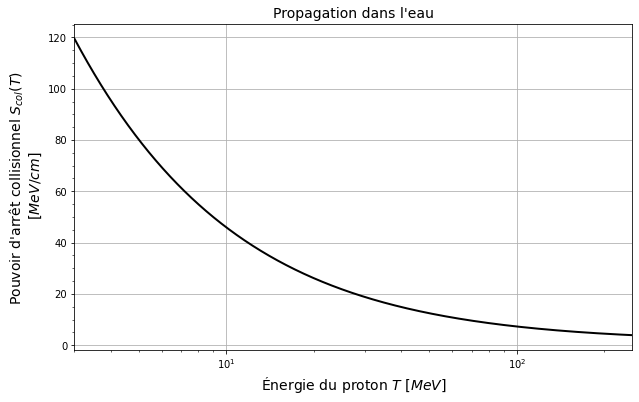

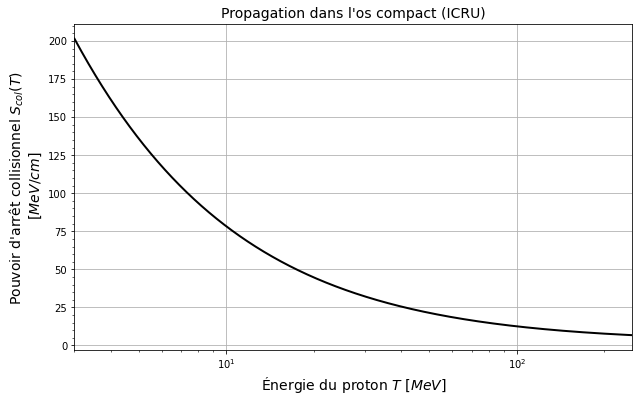

In [3]:
water = Medium(name='Water')
water.plot_Scol()

icru = Medium(name='ICRU')
icru.plot_Scol()

## Portée des protons dans la matière

### Question 2

On désire faire l'analyse dimensionnelle de l'équation de la portée des protons dans la matière. On dira que la portée $R_{CSDA}$ est de dimensions homogène s'il existe un facteur, sans unité la liant au terme de l'intégrale de l'inverse du pouvoir d'arrêt total donné par

$$ R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}} , $$

où, on sait que la portée $R_{CSDA}$ est exprimée en $[g/cm^2]$ (https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html) et que le pouvoir d'arrêt total est quant à lui exprimé en  $[MeV/cm]$. On obtient donc l'analyse dimensionnelle suivante:

- $MeV$ = $J$ = $kg m^2 s^{-2}$ = $ ML^2T^{-2}$

- $cm$ = $L$

- $g$ = $M$

$$ \dfrac{M L^{-3}}{ML^2 T^{-2} L^{-1}} \cdot ML^2 T^{-2} =  M L^{-2}, $$

ce qui correspond effectivement aux dimensions obtenues avec la portée $R_{CSDA}$ en $[g/cm^2]$. 




### Question 3 

Il est possible de justifier le fait que le pouvoir d'arrêt total est bien approximé par le pouvoir d'arrêt collisionnel aux énergies de la protonthérapie en visualisant l'ordre de grandeur des pouvoirs d'arrêt collisionnels massiques dus aux différentes interactions du proton. Pour ce faire, les courbes présentées sur le site du NIST pour l'eau et l'os compact (IRCU) sont utilisées. Le bloc suivant permet de tracer les courbes pour l'eau, puis le bloc suivant pour l'os compact.

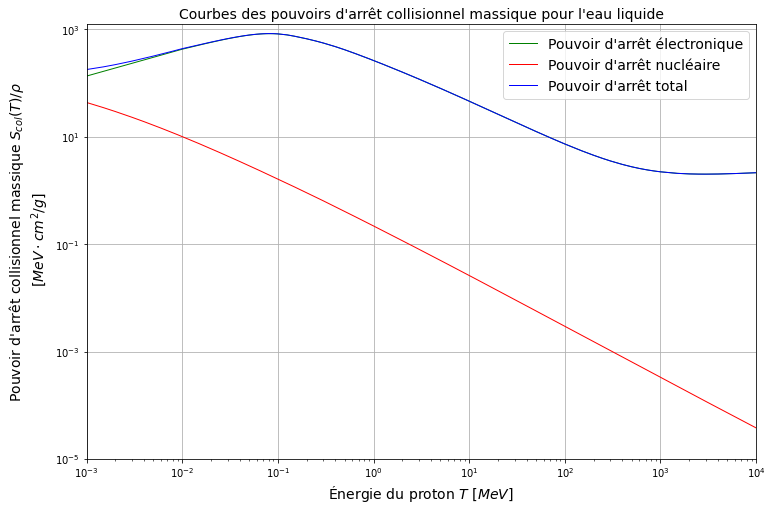

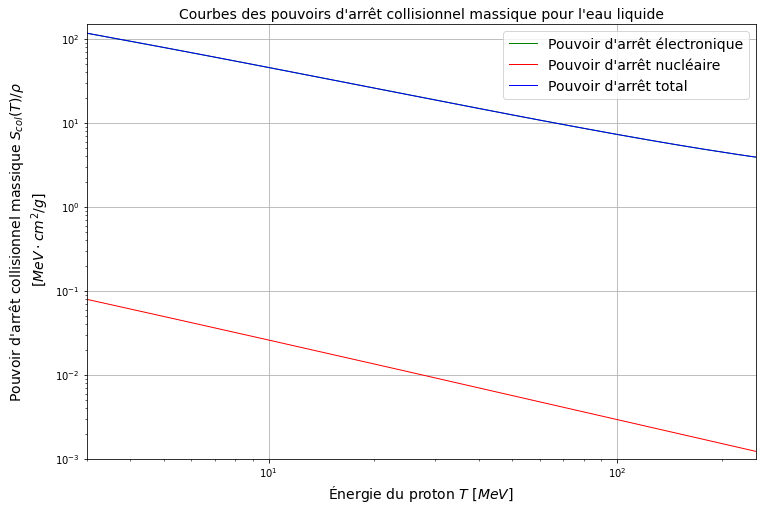

In [4]:
NIST_WATER = np.loadtxt(fname='Data/NIST_WATER.txt', skiprows=8)

min_energy = 3
max_energy = 250

x_bounds = [[min(NIST_WATER[:,0]), max(NIST_WATER[:,0])], [min_energy, max_energy]] 
y_bounds = [[0.00001, max(NIST_WATER[:,3]) + 0.5*max(NIST_WATER[:,3])], [0.001, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,1], color='g', lw=1, ls='-', label="Pouvoir d'arrêt électronique")
    line_2, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,2], color='r', lw=1, ls='-', label="Pouvoir d'arrêt nucléaire")
    line_3, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,3], color='b', lw=1, ls='-', label="Pouvoir d'arrêt total")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour l'eau liquide", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

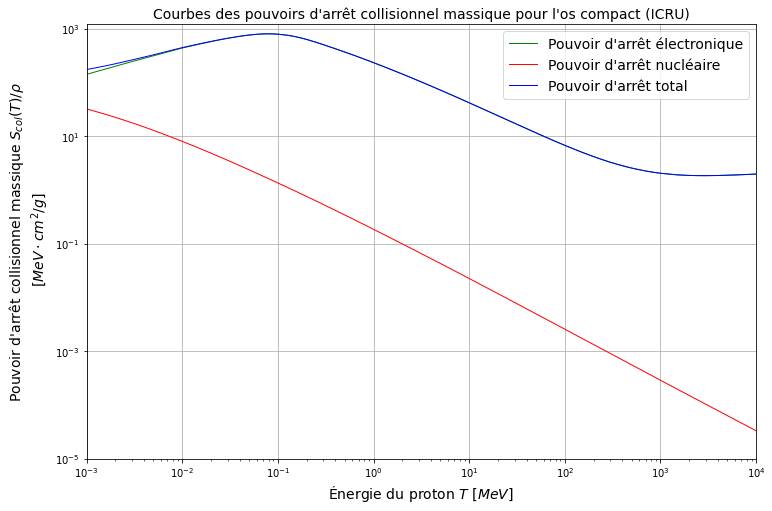

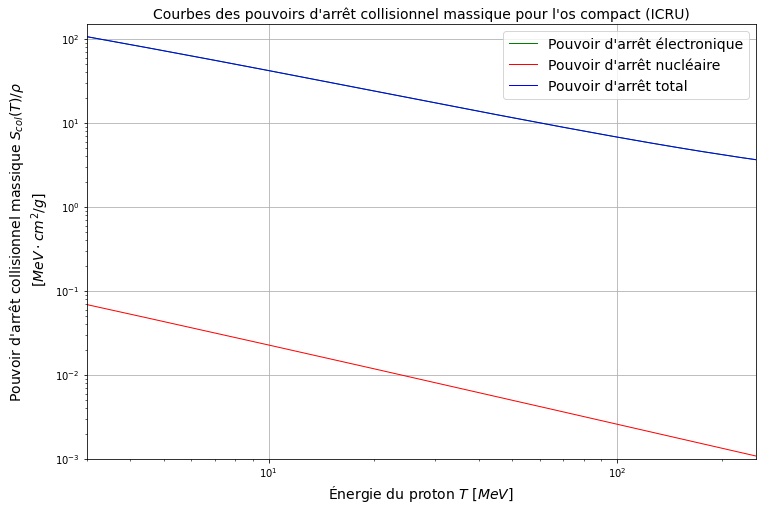

In [5]:
NIST_ICRU = np.loadtxt(fname='Data/NIST_ICRU.txt', skiprows=8)

min_energy = 3
max_energy = 250

x_bounds = [[min(NIST_ICRU[:,0]), max(NIST_ICRU[:,0])], [min_energy, max_energy]] 
y_bounds = [[0.00001, max(NIST_ICRU[:,3]) + 0.5*max(NIST_WATER[:,3])], [0.001, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,1], color='g', lw=1, ls='-', label="Pouvoir d'arrêt électronique")
    line_2, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,2], color='r', lw=1, ls='-', label="Pouvoir d'arrêt nucléaire")
    line_3, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,3], color='b', lw=1, ls='-', label="Pouvoir d'arrêt total")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour l'os compact (ICRU)", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

Le comportement des pouvoirs d'arrêt collisionnels est semblable pour l'eau et l'os compact (ICRU). On remarque que, aux énergies de la protonthérapie, le pouvoir d'arrêt collisionnel massique dû aux interactions nucléaires et pertes radiatives est d'environ 1000 fois plus faible que celui engendré par les interactions électroniques. Il est donc justifiable de les négliger dans notre calcul.

Afin de valider l'approximation utilisée dans les calculs réalisés à la question 1, il est possible de tracer les courbes calculées et les courbes provenant des données du NIST sur la même figure et pour le même intervalle d'énergie. Il est important de noter que les courbes précédemment obtenues doivent être divisées par la densité du milieu correspondant puisque les courbes du NIST sont celles du pouvoir collisionnel *massique* qui s'exprime comme $\frac{S_{col}}{\rho}$. Par ailleurs, les courbes du NIST utilisées sont celles du pouvoir collisionnel massique *total*. Bien que nos calculs tiennent en compte seulement les interactions électroniques et non les réactions nucléaires et les pertes radiatives des protons, le pouvoir collisionnel massique *total* est utilisé puisque, tel que discuté précédemment, les interactions nucléaires et radiatives sont négligeables aux énergies de protonthérapie.

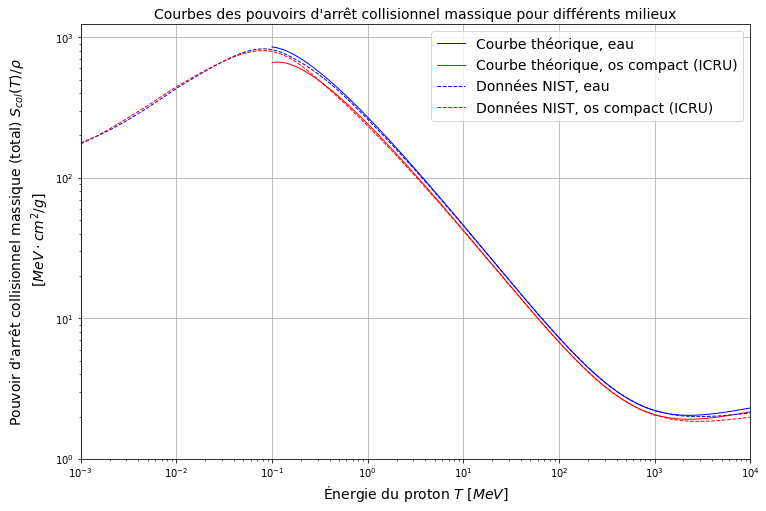

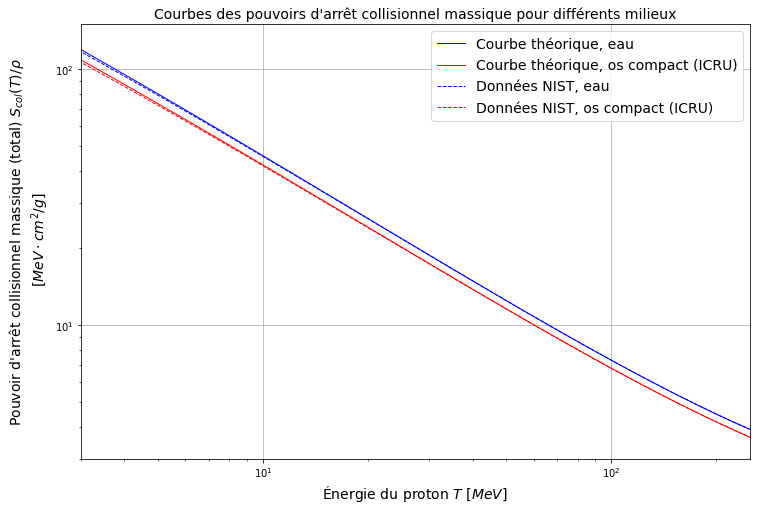

In [6]:
NIST_ICRU = np.loadtxt(fname='Data/NIST_ICRU.txt', skiprows=8)
NIST_WATER = np.loadtxt(fname='Data/NIST_WATER.txt', skiprows=8)

min_energy = 3
max_energy = 250
T = np.arange(0.1, 10000, 0.01)
icru_Scol_mass = icru.get_Scol(T)/icru.density
water_Scol_mass = water.get_Scol(T)/water.density

x_bounds = [[min(NIST_WATER[:,0]), max(NIST_WATER[:,0])], [min_energy, max_energy]] 
y_bounds = [[1, max(NIST_WATER[:,3]) + 0.5*max(NIST_WATER[:,3])], [3, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(T, water_Scol_mass, color='b', lw=1, label='Courbe théorique, eau')
    line_2, = ax.plot(T, icru_Scol_mass, color='r', lw=1, label='Courbe théorique, os compact (ICRU)')
    line_3, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,3], color='b', lw=1, ls='--', label='Données NIST, eau')
    line_4, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,3], color='r', lw=1, ls='--', label='Données NIST, os compact (ICRU)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour différents milieux", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique (total) $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

On remarque que les courbes se rapprochent bien dans l'intervalle où l'approximation utilisée (négliger les termes correctifs) est valide, soit pour des énergies de proton de plus de 3 MeV.

### Question 4

Une méthode numérique est nécessaire pour calculer la portée des protons puisque l'intégrale est difficile (voir impossible) à réaliser analytiquement. En effet, il est nécessaire d'intégrer l'inverse du pouvoir collisionnel massique en fonction de l'énergie d'un proton $T$. Le pouvoir collisionnel est donné par 

$$ S_{c o l}(T)=2 \pi r_{e}^{2} m_{e} c^{2} n_{e} \frac{1}{\beta^{2}}\left[\ln \left(\frac{\left.2 m_{e} c^{2} \beta^{2} \gamma^{2} T_{e}^{\max }\right)}{I^{2}}\right)-2 \beta^{2}\right] $$

Dans cette équation, les termes $\gamma$, $\beta$ et $T_{e}^{\max }$ ont tous une dépendance en énergie $T$, ce qui rend la résolution analytique complexe. La méthode d'intégration numérique permet d'éviter le calcul de l'intégral puisqu'elle permet de ne faire que des évaluations de la fonction.

### Question 5

In [9]:
class Integration:
    """
    Cette classe comprend deux algorithmes d'intégration numérique permettant 
    de calculer la portée de protons dans l'eau et dans l'os compact. 
    """
    
    
    def __init__(self, function) -> None:
        """
        Construction de la classe Integration.
        :param func: Fonction mathématique à intégrer
        :param algo: Type d'algorithme que l'on désire utiliser; méthode trapèze, méthode Simpson (str)
        """
        
        self._function = function

        self.integration_algos: dict = {
            "trapeze": self.trapeze_integration,
            "simpson": self.simpson_integration
        }
            

    @property
    def function(self) -> str:
        """
        Function property.
        :return: Nom de la fonction à intégrer (str)
        """
        
        return self._function.__name__
        
    
    def integrate(self, algo: str, *args, **kwargs) -> float:
        """
        Retourne l'intégrale de la fonction avec l'algorithme choisi.
        :param algo: Type d'algorithme que l'on désire utiliser; méthode trapèze, méthode Simpson (str)
        """
        
        if algo not in self.integration_algos:
            raise NameError("L'algorithme choisi n'est pas défini dans la classe. Choisir un autre algo tel {}."
                            .format(list(self.integration_algos.keys())))
        else:
            pass

        return self.integration_algos[algo](*args, **kwargs)

        
    def trapeze(self, N: int, a: float, b: float) -> float:
        """
        Réalise l'intégrale de la fonction courante avec la méthode des trapèzes.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X: np.ndarray = np.linspace(a, b, N+1)[1:-1]
        Y = self._function(X)

        h = (b - a)/N

        I = h*(0.5*self._function(a) + 0.5*self._function(b) + np.sum(Y))
    
        return I
    
    
    def adap_trapeze(self, N: int, prev_estimate: float, a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec le nesting de la méthode des trapèzes.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param prev_estimate: Valeur de l'intégrale calculé à l'itération précédente (float)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X = np.linspace(a, b, N+1)[1:-1:2]
        Y = self._function(X)
        
        h = (b - a)/N
        
        I = 1/2*prev_estimate + h*np.sum(Y)
        
        return I

    
    def trapeze_integration(self, *args, **kwargs):
        """
        Réalise l'intégrale de la fonction courante avec la méthode des trapèzes en utilisant du nesting.
        :return Integral_list, N_list, Error_list: 
                    Integral_list: Les valeurs des intégrales calculées par la méthode des trapèzes (float)
                    N_list: Les nombres de segments utilisés dans chacun des calculs d'intégral (list)
                    Error_list: Les erreurs pratiques calculées à chaque itération (list)
        """
        
        Ni = 1
        prev_estimate = self.trapeze(N=Ni, *args, **kwargs)

        N_list = []
        Integral_list = []
        Error_list = []

        max_iter = 1000
        for i in range(1, max_iter):
            Ni *= 2
            integral = self.adap_trapeze(N=Ni, prev_estimate=prev_estimate, *args, **kwargs)

            epsilon = (1/3)*(integral - prev_estimate)

            error = abs(epsilon)
            
            N_list.append(Ni)
            Integral_list.append(integral)
            Error_list.append(error)

            if error > integral*np.finfo(float).eps:
                pass
            else:
                break

            prev_estimate = integral
        
        return Integral_list, N_list, Error_list


#     def plot_R_CSDA(self):
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(1, 1, 1)
        
#         R_line, = ax.plot(N_list, R_list, linestyle='-', color='k', linewidth='2', 
#                            label="Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} "
#                            .format(error, integral, Ni))
#         ax.set_xticklabels(fontsize = 14)
#         ax.set_yticklabels(fontsize = 14)
#         ax.set_title("Portée des protons dans l'eau calculée avec la méthode de trapèze", fontsize=16)
#         ax.set_xscale('log')
#         ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
#         ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
#         ax.legend(handles=[R_line], fontsize=14, loc='best')
        
#         plt.grid()
#         plt.show()
#         plt.close(fig)

    def simpson(self, N: int, a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec la méthode de Simpson.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X_odd = np.linspace(a, b, N+1)[1:-1:2]
        X_even = np.linspace(a, b, N+1)[2:-2:2]
        Yodd = self._function(X_odd)
        Yeven = self._function(X_even)

        h = (b - a)/N

        I = 1/3*h*(self._function(a) + self._function(b) + 4*np.sum(Yodd) + 2*np.sum(Yeven))
        
        return I


    def adap_simpson(self, N: int, S_prev_estimate: float, T_prev_estimate: float,  a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec le nesting de la méthode de Simpson.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param S_prev_estimate: Valeur de la variable S obtenue à l'itération précédente (float)
        :param T_prev_estimate: Valeur de la variable T obtenue à l'itération précédente (float)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I, S, T: La valeur de l'intégrale calculé, de la variable S et de la variable T (float, float, float)
        """
        
        X_even = np.linspace(a, b, N+1)[2:-2:2]
        X_odd = np.linspace(a, b, N+1)[1:-1:2]
        Yeven = self._function(X_even)
        Yodd = self._function(X_odd)
        h = (b - a)/N

        S = S_prev_estimate + T_prev_estimate
        T = 2/3*(np.sum(Yodd))
        I = h*(S + 2*T)

        return I, S, T

    
    def simpson_integration(self, *args, **kwargs):
        """
        Réalise l'intégrale de la fonction courante avec la méthode de Simpson en utilisant du nesting.
        :return Integral_list, N_list, Error_list: 
                    Integral_list: Les valeurs des intégrales calculées par la méthode de Simpson (list)
                    N_list: Les nombres de segments utilisés dans chacun des calculs d'intégral (list)
                    Error_list: Les erreurs pratiques calculées à chaque itération (list)
        """
        
        Ni = 1
        
        assert "a" in kwargs and "b" in kwargs
        a = kwargs["a"]
        b = kwargs["b"]

        X_even = np.linspace(a, b, Ni+1)[2:-2:2]
        X_odd = np.linspace(a, b, Ni+1)[1:-1:2]
        Yeven = self._function(X_even)
        Yodd = self._function(X_odd)

        S_prev_estimate = 1/3*(self._function(a) + self._function(b) + 2*np.sum(Yeven))
        T_prev_estimate = 2/3*(np.sum(Yodd))

        prev_estimate = self.simpson(N=Ni, a=a, b=b)

        N_list = []
        Integral_list = []
        Error_list = []

        max_iter = 1000
        for i in range(1, max_iter):
            Ni *= 2

            integral, S, T = self.adap_simpson(N=Ni, S_prev_estimate=S_prev_estimate, T_prev_estimate=T_prev_estimate, 
                                               a=a, b=b)

            epsilon = (1/15)*(integral - prev_estimate)

            error = abs(epsilon)
            
            N_list.append(Ni)
            Integral_list.append(integral)
            Error_list.append(error)

            if error > integral*np.finfo(float).eps:
                pass
            else:
                break

            prev_estimate = integral
            S_prev_estimate = S
            T_prev_estimate = T
        
        return Integral_list, N_list, Error_list


#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(1, 1, 1)
#         eau, = plt.plot(N_list, R_list, linestyle='-', color='b', linewidth='2', label="R eau \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} " .format(error, integral, Ni))
#         icru, = plt.plot(N_list, R_list, linestyle='-', color='r', linewidth='2', label="R icru \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} " .format(error, integral, Ni))
#         plt.xticks(fontsize = 16)
#         plt.yticks(fontsize = 16)
#         ax.set_title("Portée des protons calculée avec la méthode de Simpson", fontsize=16)
#         ax.set_xscale('log')
#         ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
#         ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
#         ax.legend(handles=[eau, icru], fontsize=14, loc='best')
#         fig = plt.gcf()
#         fig.set_size_inches(12, 8)
#         plt.show()


def f_water(T):
    
    return water.density/water.get_Scol(T)


def f_icru(T):
    
    return icru.density/icru.get_Scol(T)


water_integration = Integration(f_water)
print(water_integration.function)
print(water_integration.integrate(algo='trapeze', a=3, b=150))
print(water_integration.integrate(algo='simpson', a=3, b=150))

icru_integration = Integration(f_icru)
print(icru_integration.function)
print(icru_integration.integrate(algo='trapeze', a=3, b=150))
print(icru_integration.integrate(algo='simpson', a=3, b=150))

# Change output list for dict
# Integrate with Medium class


f_water
([15.287786864644566, 15.624328942655506, 15.71806879690796, 15.743401849563874, 15.750045587447953, 15.751746137768421, 15.75217512666163, 15.752282671846563, 15.75230957828169, 15.752316306178587, 15.75231798823381, 15.752318408752686, 15.752318513882724, 15.752318540165252, 15.752318546735886, 15.752318548378543, 15.752318548789209, 15.752318548891875, 15.752318548917543, 15.75231854892396, 15.752318548925562, 15.752318548925963, 15.752318548926052, 15.752318548926091, 15.752318548926109, 15.752318548926102], [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864], [0.3915614909379048, 0.11218069267031319, 0.031246618084151596, 0.008444350885304411, 0.00221457929469319, 0.0005668501068226324, 0.0001429962977361754, 3.584839497783321e-05, 8.968811708716846e-06, 2.2426322991246175e-06, 5.606850740728456e-07, 1.4017295886977382e-07, 3.504334600279435e-08, 8.760842

In [14]:
def trapeze(N, a, b):   
    X = np.linspace(a, b, N+1)[1:-1]
    Y_water = f_water(X)
    Y_icru = f_icru(X)
    
    h = (b - a)/N
    
    I_water = h*(0.5*f_water(a) + 0.5*f_water(b) + np.sum(Y_water))
    I_icru = h*(0.5*f_icru(a) + 0.5*f_icru(b) + np.sum(Y_icru))
    
    return I_water, I_icru

def adap_trapeze(N, prev_estimate, a, b):
    X = np.linspace(a, b, N+1)[1:-1:2]
    Y_water = f_water(X)
    Y_icru = f_icru(X)
    h = (b - a)/N
    
    return 1/2*prev_estimate + h * np.sum(Y_water), 1/2*prev_estimate + h*np.sum(Y_icru)


15.287786864644566
15.624328942655506
15.71806879690796
15.743401849563874
15.750045587447953
15.751746137768421
15.75217512666163
15.752282671846563
15.75230957828169
15.752316306178587
15.75231798823381
15.752318408752686
15.752318513882724
15.752318540165252
15.752318546735886
15.752318548378543
15.752318548789209
15.752318548891875
15.752318548917543
15.75231854892396
15.752318548925562
15.752318548925963
15.752318548926052
15.752318548926091
15.752318548926109


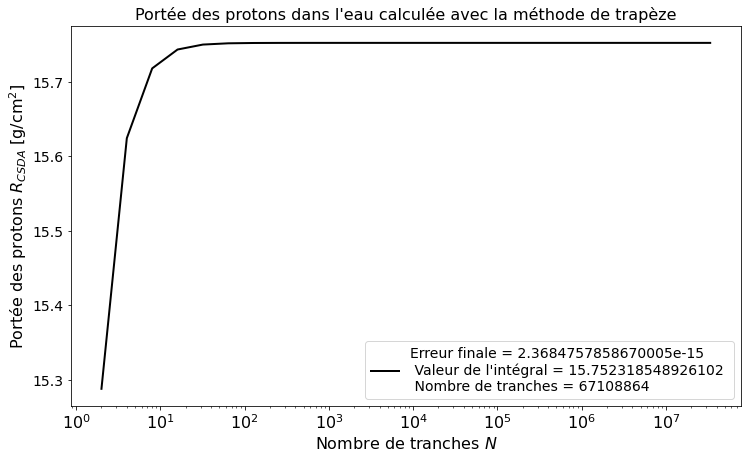

In [15]:

Ni = 1

a, b = 3, 150
prev_estimate = trapeze(N=Ni, a=a, b=b)[0]

N_list = []
R_list = []

max_iter = 1000
for i in range(1, max_iter):
    Ni *= 2
    integral = adap_trapeze(N=Ni, prev_estimate=prev_estimate, a=a, b=b)[0]
    
    epsilon = (1/3)*(integral - prev_estimate)
    
    error = abs(epsilon)
    
    if error > integral*np.finfo(float).eps:
        pass
    else:
        break
        
    
    prev_estimate = integral
    print(prev_estimate)
    
    N_list.append(Ni)
    R_list.append(integral)
    
    
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
portee, = plt.plot(N_list, R_list, linestyle='-', color='k', linewidth='2', label="Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} " .format(error, integral, Ni))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
ax.set_title("Portée des protons dans l'eau calculée avec la méthode de trapèze", fontsize=16)
ax.set_xscale('log')
ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
ax.legend(handles=[portee], fontsize=14, loc='best')
fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.show()

In [ ]:
#Calcul de l'erreur d'Approximation 

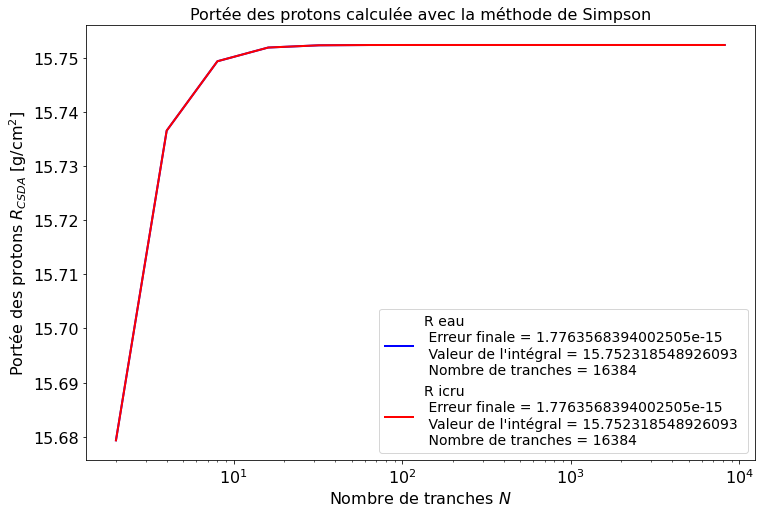

In [99]:

def Simpson(N, a, b):
    X_odd = np.linspace(a, b, N+1)[1:-1:2]
    X_even = np.linspace(a, b, N+1)[2:-2:2]
    Yodd_water = f_water(X_odd)
    Yeven_water = f_water(X_even)
    Yodd_icru = f_icru(X_odd)
    Yeven_icru = f_icru(X_even)
    
    h = (b - a)/N
    
    I_water = 1/3*h*(f_water(a) + f_water(b) + 4*np.sum(Yodd_water) + 2*np.sum(Yeven_water))
    I_icru = 1/3*h*(f_icru(a) + f_icru(b) + 4*np.sum(Yodd_icru) + 2*np.sum(Yeven_icru))
    
    return I_water, I_icru



def adap_Simpson(N, S_prev_estimate, T_prev_estimate,  a, b):
    X_even = np.linspace(a, b, N+1)[2:-2:2]
    X_odd = np.linspace(a, b, N+1)[1:-1:2]
    Yeven_water = f_water(X_even)
    Yodd_water = f_water(X_odd)
    h = (b - a)/N
    
    S = S_prev_estimate + T_prev_estimate
    T = 2/3*(np.sum(Yodd_water))
    
    return h*(S + 2*T), S, T


Ni = 1
a, b = 3, 150

X_even = np.linspace(a, b, Ni+1)[2:-2:2]
X_odd = np.linspace(a, b, Ni+1)[1:-1:2]
Yeven_water = f_water(X_even)
Yodd_water = f_water(X_odd)


S_prev_estimate = 1/3*(f_water(a) + f_water(b) + 2*np.sum(Yeven_water))
T_prev_estimate = 2/3*(np.sum(Yodd_water))

prev_estimate = Simpson(N=Ni, a=a, b=b)[0]

N_list = []
R_list = []

max_iter = 1000
for i in range(1, max_iter):
    Ni *= 2
    
    integral, S, T = adap_Simpson(N=Ni, S_prev_estimate=S_prev_estimate, T_prev_estimate=T_prev_estimate, a=a, b=b)
    
    epsilon = (1/15)*(integral - prev_estimate)
    
    error = abs(epsilon)
   
    
    if error > integral*np.finfo(float).eps:
        pass
    else:
        break
        
    prev_estimate = integral
    S_prev_estimate = S
    T_prev_estimate = T
    
    N_list.append(Ni)
    R_list.append(integral)
    

    
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
eau, = plt.plot(N_list, R_list, linestyle='-', color='b', linewidth='2', label="R eau \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} " .format(error, integral, Ni))
icru, = plt.plot(N_list, R_list, linestyle='-', color='r', linewidth='2', label="R icru \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} " .format(error, integral, Ni))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Portée des protons calculée avec la méthode de Simpson", fontsize=16)
ax.set_xscale('log')
ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
ax.legend(handles=[eau, icru], fontsize=14, loc='best')
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()



 

### Question 6

On désire déterminer analytiquement l'expression de la dérivée du pouvoir d'arrêt en terme de T. On utilise le théorème de dérivation des fonctions composées et les simplifications suivantes:

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{dS_{\text{col}}(T)}{d \gamma} \cdot \dfrac{d \gamma}{dT} $$ 

$$ a = 2m_ec^2, b = 1 + (\dfrac{m_e}{m_p})^2, \delta = 2 \dfrac{m_e}{m_p} $$

$$ U = 2\pi r_e^{2}m_e c^2 n_e,  k = \dfrac{a^2}{I^2} $$

$$ \gamma ^2 \beta^2 = (\gamma ^2 -1) $$

Après les simplications, on peut exprimer $S_{\text{col}}(T)$ de la façon suivante:

$$ S_{\text{col}}(T) = U \cdot \left ( \left (\dfrac{\gamma ^2}{\gamma ^2 - 1} \right) \ln \left (\dfrac{k(\gamma ^2 -1)^2}{b+\delta \gamma} \right ) - 2 \right ) $$

La dérivée du pouvoir d'arrêt par rapport à $\gamma$ est donnée par

$$ \dfrac{dS_{\text{col}}(T)}{d \gamma} = U \cdot \left (  \left (\dfrac{-2 \gamma}{(\gamma ^2 -1)^2} \right )  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (\dfrac{\gamma ^2}{\gamma ^2 - 1} \right) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right )  $$

De plus,

$$ T = (\gamma -1) m_p c^2 \Rightarrow \gamma = \dfrac{T}{m_p c^2} +1 $$

Alors,

$$\dfrac{d \gamma}{dT} = \dfrac{1}{c^2 m_p} $$

On obtient donc l'expression de la dérivée de $S_{\text{col}}(T)$ par rapport à $T$,

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{U}{c^2 m_p} \cdot \left (  \left (\dfrac{-2 \gamma}{(\gamma ^2 -1)^2} \right )  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (1 - \dfrac{1}{\gamma^2} \right ) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right) $$

On obtient alors l'expression suivante en substituant les simplifications effectuées:

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{2\pi r_e^{2}m_e c^2 n_e}{c^2 m_p} \cdot \left (  \left (\dfrac{-2 \left (\dfrac{T}{m_p c^2} +1 \right )}{\left ( \left (\dfrac{T}{m_p c^2} +1 \right )^2 -1 \right )^2} \right )  \ln \left (\dfrac{k \left ( \left (\dfrac{T}{m_p c^2} +1 \right )^2 -1 \right)^2}{\left (\dfrac{m_e}{m_p}\right )^2 + 2 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )} \right) + \left (1 - \dfrac{1}{\left (\dfrac{T}{m_p c^2} +1 \right )^2} \right ) \left (\dfrac{4 \left (\dfrac{m_e}{m_p} \right )^2 \left (\dfrac{T}{m_p c^2} +1 \right) + 6 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )^2 + \dfrac{T}{m_p c^2} +1}{\left ( \left (\dfrac{T}{m_p c^2} +1 \right ) ^2 -1 \right) \left ( \left (\dfrac{m_e}{m_p} \right )^2+2 \dfrac{m_e}{m_p} \dfrac{T}{m_p c^2} +1 \right )} \right ) \right) $$


$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{2\pi r_e^{2}m_e c^2 n_e}{c^2 m_p} \cdot \left ( \dfrac{-2 m_p^3 c^6 (m_p c^2 + T)}{T^2 (2 m_p c^2 + T^2)^2} \right ) \cdot \ln \left ( \dfrac{k T^2 (m_p c^2 + T)^2}{m_p^2 c^6 m_e (2 m_p c^2 + c^2 m_e + 2T)} \right ) + \left ( \dfrac{T (2 m_p c^2 + T)}{(m_p c^2 + T)^2} \right )\cdot \left ( \dfrac{m_p c^2 (m_p c^2 + T) (m_p ^2 c^2 + 6 m_p c^2 m_e + 4 c^2 m_e ^2 + 6 m_e T)}{T(2 m_p c^2 + T)( m_p ^2 c^2 + c^2 m_e^2 + 2 m_e T)} \right )  $$

In [30]:
U, gamma, k, b, delta, T, m_p = sym.symbols('U gamma k b delta T m_p') # Attention! Ici m_p est en MeV.

Scol = U*(((1-1/(gamma**2))**-1)*sym.log((k*(gamma**2-1)**2)/(b+delta*gamma))-2)
dScol_dgamma = sym.diff(Scol, gamma)

_gamma = T/(m_p) + 1
dgamma_dT = sym.diff(_gamma, T)

dScol_dT = dScol_dgamma*dgamma_dT

dScol_dT_lambdify = sym.lambdify(args=[U, gamma, k, b, delta, T, m_p], expr=dScol_dT, modules="numpy")


def get_Scol_derivative(self, T):
    
    r_e: float = sc.physical_constants["classical electron radius"][0] * 100 # [cm]
    m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0] # [MeV]
    m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0] # [MeV]

    n_e = self.get_electronic_density() # [cm^-3]
    I = self._mean_excitation_energy/1e6 # [MeV] 
    
    U = 2*np.pi*(r_e**2)*m_e*n_e
    a = 2*m_e
    b = 1 + (m_e/m_p)**2
    delta = 2*m_e/m_p
    k = (a**2)/(I**2)
    gamma = self.get_gamma(T)
    
    return dScol_dT_lambdify(U, gamma, k, b, delta, T, m_p)


Medium.get_Scol_derivative = get_Scol_derivative


def plot_Scol_derivative(self):

    min_energy = 3
    max_energy = 250
    T = np.arange(min_energy, max_energy, 0.01)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line, = ax.plot(T, self.get_Scol_derivative(T), color='k', lw=2)
    ax.set_xscale('log')

    if self.name == 'Water':
        ax.set_title("Propagation dans l'eau", fontsize=14)
    elif self.name == 'ICRU':
        ax.set_title("Propagation dans l'os compact (ICRU)", fontsize=14)
    else:
        raise NameError('Matériau inconnu')

    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim([min(T), max(T)])
    ax.set_ylabel(r"Dérivée du pouvoir d'arrêt collisionnel $\frac{\mathrm{d}S_{col}(T)}{\mathrm{d}T}$" "\n [$cm^{-1}$]", 
                  fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)


Medium.plot_Scol_derivative = plot_Scol_derivative


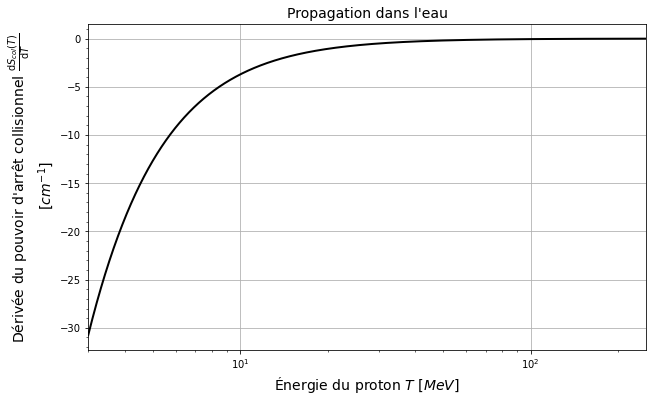

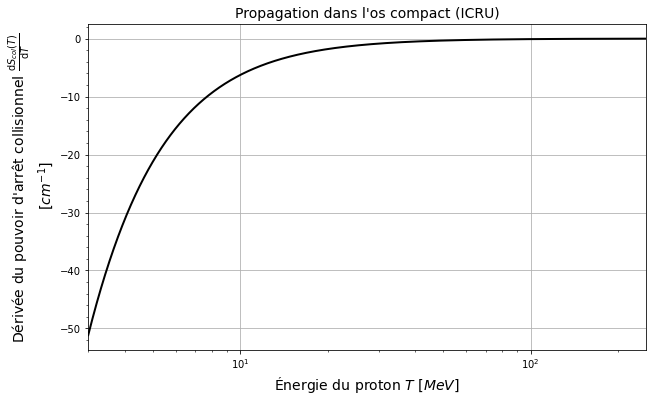

In [31]:
water.plot_Scol_derivative()
icru.plot_Scol_derivative()

### Question 7

**Tableau 1 : Portée calculée par différentes méthodes d'intégration et les erreurs d'approximation correspondantes.**<br>

| Méthode d'intégration | Milieu de propagation | Portée $R_{CSDA}$ | Erreur d'approximation calculé | Erreur d'approximation pratique |
|:---------------------:|:---------------------:|:-----------------:|:------------------------------:|:-------------------------------:|
|          -             |            -           |     *[g/cm^2]*    |           *[g/cm^2]*           |            *[g/cm^2]*           |
|        Trapèze        |          Eau<br><br>Os compact (ICRU)          |        15.752318556304951<br><br>0           |        0<br><br>0                        |      5.921189464667501$\cdot$ 10$^{-16}$ <br><br>0      |
|        Simpson        |          Eau<br><br>Os compact (ICRU)          |       15.75231855630495<br><br>0            |                -<br>-               |                1.8947806286936005$\cdot$ 10$^{-15}$<br><br>0                 |

Observation

## Optimisation

### Question 8

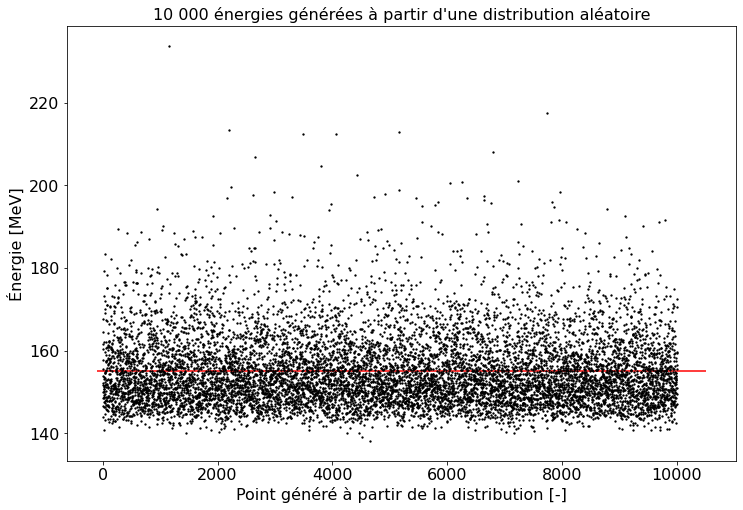

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

distribution = moyal.rvs(loc=150, scale=4, size=10000)
mean = np.mean(distribution)

plt.plot(distribution, 'ko', markersize='1.3')
plt.hlines(mean, -100, 10500, color='r', linestyle='-')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("10 000 énergies générées à partir d'une distribution aléatoire", fontsize=16)
ax.set_xlabel("Point généré à partir de la distribution [-]", fontsize=16)
ax.set_ylabel("Énergie [MeV]", fontsize=16)
fig = plt.gcf()
plt.show()

### Question 9

### Question 10

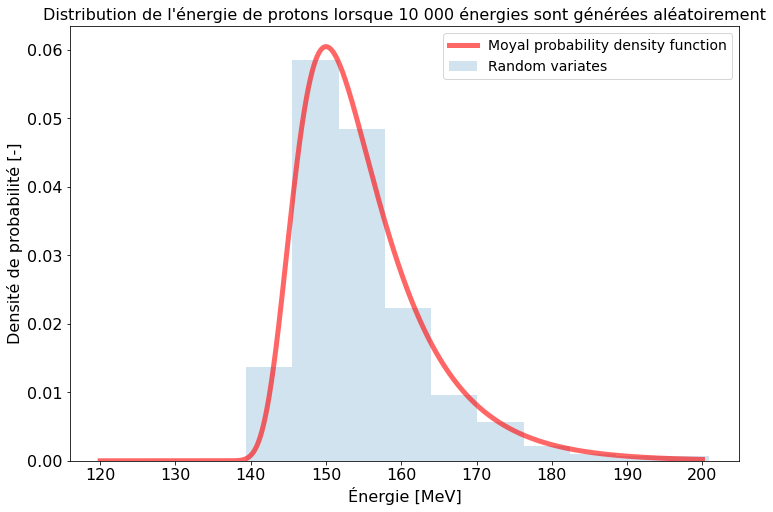

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

x = np.linspace(120, 200, 10000)
y = moyal.pdf(x, loc=150, scale=4)
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='moyal pdf')

# rv = moyal()
# ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = moyal.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], moyal.cdf(vals))

distribution = moyal.rvs(loc=150, scale=4, size=1000)
ax.hist(distribution, density=True, histtype='stepfilled', alpha=0.2)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Distribution de l'énergie de protons lorsque 10 000 énergies sont générées aléatoirement", fontsize=16)
ax.set_xlabel("Énergie [MeV]", fontsize=16)
ax.set_ylabel("Densité de probabilité [-]", fontsize=16)
ax.legend(["Moyal probability density function", "Random variates"], fontsize=14, loc='best')
fig = plt.gcf()
plt.show()